In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# !kill -9 -1

In [36]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive
!free -g

              total        used        free      shared  buff/cache   available
Mem:             12          11           0           0           1           0
Swap:             0           0           0


In [2]:
!ls

datalab  drive


In [0]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from scipy.ndimage.interpolation import shift
from keras.models import load_model
import keras
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
nb_samples = 25000
nb_words  = 500

In [0]:
def return_text(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return lines

In [0]:
# test_from = return_text('/data/test.from')
train_from = return_text('drive/projects/chatbot-reddit/data/train.from')
# test_to = return_text('drive/projects/chatbot-reddit/data/test.to')
train_to = return_text('drive/projects/chatbot-reddit/data/train.to')

In [0]:
def clean_sentences(sentences):
    n_sentences=[]
    temp = ''
    for sentence in sentences:
        if '\n' in sentence:
            loc = sentence.find('\n')
        temp = "sp "+sentence[:loc] +" newlinechar"
        n_sentences.append(temp)
        temp=''
    return n_sentences

In [0]:
cleaned_trainfrom = clean_sentences(train_from)
cleaned_trainto = clean_sentences(train_to)

In [9]:
cleaned_trainfrom[1]

"sp Nitrate, not nitrogen. newlinechar Nitrate = NO3, so there's your Oxygen. newlinechar  newlinechar"

In [0]:
tokenizer = Tokenizer(num_words = nb_words,lower=True)
tokenizer.fit_on_texts(cleaned_trainfrom + cleaned_trainto)

In [0]:
train_from_sequences = tokenizer.texts_to_sequences(cleaned_trainfrom)
train_to_sequences = tokenizer.texts_to_sequences(cleaned_trainto)

In [0]:
# test_to_sequences = tokenizer.texts_to_sequences(test_to)
# test_from_sequences = tokenizer.texts_to_sequences(test_from)

In [0]:
max_seq_train_from = max([len(seq) for seq in train_from_sequences])
max_seq_train_to = max([len(seq) for seq in train_to_sequences])

In [14]:
max_seq_train_from,max_seq_train_to

(81, 70)

In [0]:
data_trainfrom = pad_sequences(train_from_sequences, maxlen=max_seq_train_from)
data_trainto = pad_sequences(train_to_sequences, maxlen=max_seq_train_to)

In [0]:
# data_testfrom = pad_sequences(train_from_sequences, maxlen=max_seq_train_from)
# data_testto = pad_sequences(train_to_sequences, maxlen=max_seq_train_to)

In [17]:
data_trainfrom.shape,data_trainto.shape

((28778, 81), (28778, 70))

In [0]:
data_trainfrom = data_trainfrom[:nb_samples]
data_trainto = data_trainto [:nb_samples]

In [19]:
data_trainfrom.shape,data_trainto.shape

((25000, 81), (25000, 70))

In [0]:
def shift2(arr,num):
    arr=np.roll(arr,num)
    if num<0:
         np.put(arr,range(len(arr)+num,len(arr)),0)
    elif num > 0:
         np.put(arr,range(num),0)
    return arr

In [0]:
target_data = shift2(data_trainto, -1)
target_data = target_data[:nb_samples]

In [22]:
new_tokens = {}
for token, val in  tokenizer.word_index.items():
  if(val<=nb_words):
    if re.match('^[a-zA-Z0-9]',token ):
        new_tokens[token] = val
  else:
    break
num_tokens = len(new_tokens) +1
num_tokens

500

In [0]:
index2word = {}
for word,i in new_tokens.items():
    index2word[i] = word

In [24]:
index2word[1]

'newlinechar'

In [25]:
new_tokens['sp']

2

In [0]:
X = np.zeros((nb_samples,max_seq_train_from, num_tokens+1), dtype='float32')
X_context = np.zeros((nb_samples,max_seq_train_to, num_tokens+1), dtype='float32')
Y = np.zeros((nb_samples,max_seq_train_to, num_tokens+1), dtype='float32')


for i, (input_text, target_text) in enumerate(zip(train_from, train_to)):
    for t, word in enumerate(input_text.split(' ')):
      if word in new_tokens and i<nb_samples:   
        X[i, t, new_tokens[word]] = 1.
    for t, word in enumerate(target_text.split(' ')):
        if word in new_tokens and i<nb_samples:
          # decoder_target_data is ahead of decoder_input_data by one timestep
            X_context[i, t, new_tokens[word]] = 1.
            
            if t > 0:             
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              Y[i, t - 1, new_tokens[word]] = 1.

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense 
from keras.models import Model
from keras import optimizers


latent_dim = 256

# # Defining Encoder model
encoder_inputs                    = Input(shape=(None, num_tokens+1),     name='encoder_inputs')
encoder                           = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [0]:
# # Defining Decoder model
decoder_inputs = Input(shape=(None, num_tokens+1), name='decoder_inputs')
decoder_lstm          = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense         = Dense(num_tokens+1, activation='softmax', name='decoder_dense')
decoder_outputs       = decoder_dense(decoder_outputs)

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model  = load_model('drive/projects/chatbot-reddit/models/chatbot_valF.h5')

In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 501)    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 501)    0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 776192      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  776192      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]               
          

In [0]:
callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath='drive/projects/chatbot-reddit/models/chatbot_valF.h5',
            monitor='val_loss',
            save_best_only=True,
        ),
]

In [37]:
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!

epochs     = 30  # Number of epochs to train for.
batch_size = 256   # Batch size for training.

history = model.fit([X, X_context], Y,
          batch_size=batch_size,            
          epochs=1,
          validation_split=0.2,
          callbacks = callbacks_list)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 38s 2ms/step - loss: 0.4481 - val_loss: 0.4729


/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [0]:
# model.save('../models/chatbot_temp.h5')


In [0]:
def sample(preds, temperature= 1.0):
    preds = np.reshape(preds,preds.shape[-1])
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds, 1)
    return np.argmax(probas)

In [0]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states  = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model   = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [40]:
index2word[1]

'newlinechar'

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_tokens+1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, new_tokens['sp']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = sample(output_tokens,0.1 )
#         sampled_token_index = np.argmax(output_tokens)
        if sampled_token_index in index2word:
          sampled_word        = index2word[sampled_token_index]
          if (sampled_word == 'newlinechar'):
              stop_condition = True
              continue
          decoded_sentence   += sampled_word+" "

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == 'newlinechar' or
           len(decoded_sentence) > max_seq_train_to):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_tokens+1))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [93]:
predict_range = range(10, 12)
for seq_index in predict_range:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = X[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Questions:', train_from[seq_index])
    print('Reply:', decoded_sentence)

-
Questions: you're the one who put the question mark there, dude.

Reply: well 1 rather ever e search car understand try yourself whole law car lt 
-
Questions: Oh, March 1st, huh, that's pretty old. newlinechar  newlinechar I have unopened milk cartons at my parents' house.  newlinechar  newlinechar It's from high school. newlinechar  newlinechar I've been out of college for three years.

Reply: and those bit some like guy called us bit they're eat title day happy is 


In [0]:
def make_inference(sentence):
    input_text_seq = tokenizer.texts_to_sequences(sentence)
    input_data_padded = pad_sequences(train_to_sequences, maxlen=max_seq_train_from)
    input_data= np.zeros((1, max_seq_train_from, num_tokens+1), dtype= 'float32')
    
    for t, word in enumerate(sentence.split(' ')):
      if word in new_tokens:   
        input_data[0, t, new_tokens[word]] = 1.  
        
    decoded_sentence = decode_sequence(input_data)
    print('Question:', sentence)
    print('Reply:', decoded_sentence)

In [79]:
make_inference("life")

Question: life
Reply: joke not did apparently best non wrong usually when call love you seriously 


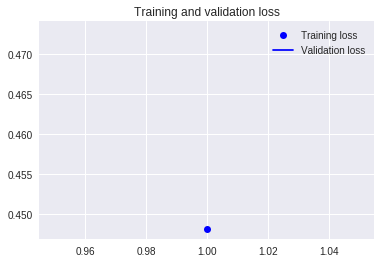

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()